In [1]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from itertools import product
import itertools
import pickle

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Local Imports
from picking.p_picking import p_picking_all, p_picking_each, p_picking_val
from picking.utils import optimize_parameters, load_best_params
from picking.plot import *


/home/lptv/anaconda3/envs/trigger_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_files(path, extensions):
    '''
    Entrega de vuelta un diccionario con la extensión del archivo como llave, y el path a cada archivo como valor

    '''
    file_list = {ext: [] for ext in list(extensions)}
    for root, dirs, files in os.walk(path):
        for file in files:
            for ext in extensions:
                if file.endswith(ext):
                    file_list[ext].append(os.path.join(root, file))

    return file_list


def sort_files(file_dic, extension):
    '''
    Junta los archivos por carpeta y canal. Queda un diccionario que tiene como llave la carpeta y el canal, 
    y como valor una lista con los paths a los archivos de esa carpeta y canal.   
    '''
    # Diccionario para almacenar los archivos por carpeta y canal
    grouped_files = defaultdict(list)
    key_names = []
    
    # Ordenar los archivos alfabéticamente antes de procesarlos
    sorted_files = sorted(file_dic[extension])
    
    for file in sorted_files:
        # Extraer la carpeta y el canal del path del archivo
        parts = os.path.split(file)
        folder = parts[0]  # La carpeta es el primer elemento en el path
        channel = parts[1].split('_')[0]  # El canal es el primer elemento en el nombre del archivo
        key = os.path.join(folder, channel)
        if [key] not in key_names:
            key_names.append([key])
        # Agrupar los archivos
        grouped_files[key].append(file)

    key_names = list(itertools.chain(*key_names))
    return grouped_files, key_names



In [3]:
path = os.path.join('señales_sismos', 'BHZ')
files_bhz = find_files(path, ['.mseed'])
files_bhz_ch, key_names_bhz = sort_files(files_bhz, '.mseed')

In [4]:
key_names_bhz 

['señales_sismos/BHZ/AC04',
 'señales_sismos/BHZ/AC05',
 'señales_sismos/BHZ/CO05',
 'señales_sismos/BHZ/CO10']

<img src="diagrama.png">

# 1. Preprocesamiento de las trazas

## 1.1. Lectura de las trazas sísmicas

In [5]:
#estación AC04
AC04_st = files_bhz_ch[key_names_bhz[0]]
st_AC04_raw = read(AC04_st[0])
st_AC04_raw += read(AC04_st[1])
st_AC04_raw += read(AC04_st[2])


#estación adyacente 1: AC05
AC05_st = files_bhz_ch[key_names_bhz[1]]
st_AC05_raw = read(AC05_st[0])
st_AC05_raw += read(AC05_st[1])
st_AC05_raw += read(AC05_st[2])


#estación adyacente 2: CO05
CO05_st = files_bhz_ch[key_names_bhz[2]]
st_CO05_raw = read(CO05_st[0])
st_CO05_raw += read(CO05_st[1])
st_CO05_raw += read(CO05_st[2])

#estación adyacente 3: CO10
CO10_st = files_bhz_ch[key_names_bhz[3]]
st_CO10_raw = read(CO10_st[0])
st_CO10_raw += read(CO10_st[1])
st_CO10_raw += read(CO10_st[2])

In [6]:
st_AC04_raw

3 Trace(s) in Stream:
C1.AC04..BHE | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.AC04..BHN | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.AC04..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples

### 1.1.1. Visualización de la señal AC04

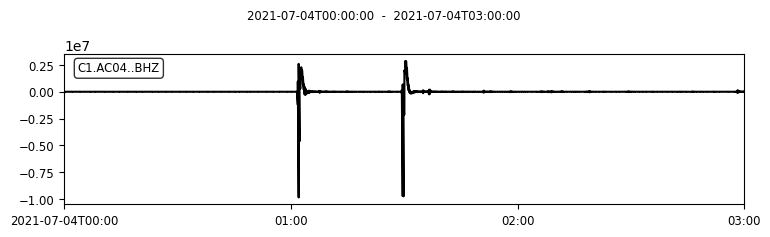

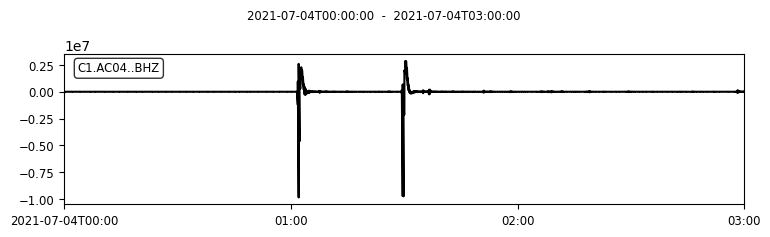

In [7]:
st_AC04_raw[2].plot(startime = st_AC04_raw[2].stats.starttime + 60*60 , endtime = st_AC04_raw[2].stats.starttime + 60*60*3)

## 1.2. Eliminación de respuesta de instrumentos

In [8]:
def remove_response(trace: Trace, inventory_filepath: str, remove_type: str = "obspy"):
    """
    Remove instrument response

    Args:
        trace (Trace): Trace object from obspy
        inventory_folder (str): Path to inventory folder
    """
    from obspy import read_inventory

    assert isinstance(trace, Trace), "trace must be a Trace object from obspy"

    trace_removed = trace.copy()

    inv = read_inventory(inventory_filepath)
        # Remove instrument response
    if remove_type == "obspy":
        trace_removed.remove_response(
            inventory=inv,
            output="VEL",
            zero_mean=False,
        )
    elif remove_type == "scalar":
        resp = inv.get_response(seed_id=trace_removed.get_id(), datetime=trace_removed.stats.starttime)
        #trace_removed.data *= 1/inv[0][0].response.instrument_sensitivity.value
        trace_removed.data *= 1/resp.instrument_sensitivity.value
        
    """inv = read_inventory(inventory_filepath)
        resp = inv.get_response(
            seed_id=trace_removed.get_id(), 
            datetime=trace_removed.stats.starttime)
        poles = resp.get_paz().poles
        zeros = resp.get_paz().zeros
        #gain = np.prod(list(map(lambda stage: stage.stage_gain, resp.response_stages)))
        sensitivity = resp.instrument_sensitivity.value
        for stage in resp.response_stages[::-1]:
            gain = stage.stage_gain
            paz_sts2 = {'poles': poles,
                'zeros': zeros,
                'gain': 1/gain,
                'sensitivity': sensitivity}
            trace_removed.simulate(paz_remove=paz_sts2)"""

    return trace_removed

In [9]:
remove_AC04 = os.path.join("inventory", "C1_AC04.xml")
remove_AC05 = os.path.join("inventory", "C1_AC05.xml")
remove_CO05 = os.path.join("inventory", "C1_CO05.xml")
remove_CO10 = os.path.join("inventory", "C1_CO10.xml")


In [10]:
st_AC04_resp = st_AC04_raw.copy().sort()
st_AC05_resp = st_AC05_raw.copy().sort()
st_CO05_resp = st_CO05_raw.copy().sort()
st_CO10_resp = st_CO10_raw.copy().sort()

In [11]:
st_AC04_resp

3 Trace(s) in Stream:
C1.AC04..BHE | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.AC04..BHN | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.AC04..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples

In [12]:
st_AC04_removed = remove_response(st_AC04_resp.select(channel='BHZ')[0], remove_AC04 , 'obspy')
st_AC05_removed = remove_response(st_AC05_resp.select(channel='BHZ')[0], remove_AC05 , 'obspy')
st_CO05_removed = remove_response(st_CO05_resp.select(channel='BHZ')[0], remove_CO05 , 'obspy')
st_CO10_removed = remove_response(st_CO10_resp.select(channel='BHZ')[0], remove_CO10 , 'obspy')

st_AC04_resp[2] = st_AC04_removed
st_AC05_resp[2] = st_AC05_removed
st_CO05_resp[2] = st_CO05_removed 
st_CO10_resp[2] = st_CO10_removed

assert(st_AC04_resp.select(channel='BHZ')[0] == st_AC04_removed)
assert(st_AC05_resp.select(channel='BHZ')[0] == st_AC05_removed)
assert(st_CO05_resp.select(channel='BHZ')[0] == st_CO05_removed)
assert(st_CO10_resp.select(channel='BHZ')[0] == st_CO10_removed)

### 1.2.1. Visualización señal sin respuesta instrumental

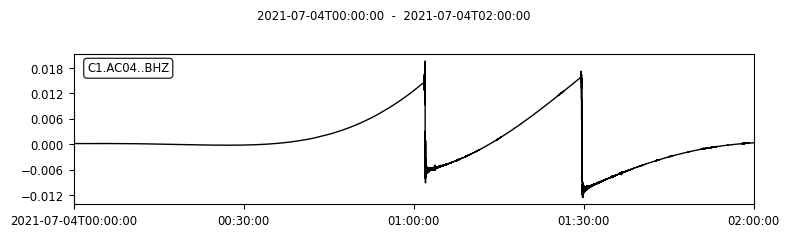

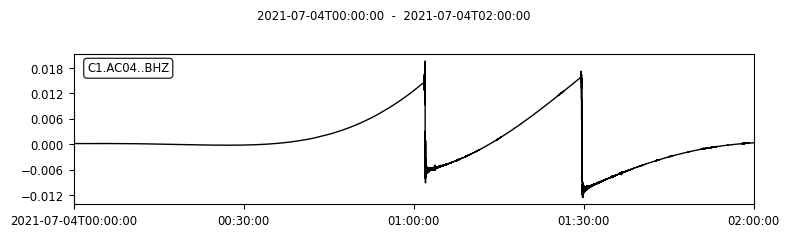

In [13]:
st_AC04_resp[2].plot(startime = st_AC04_resp[2].stats.starttime + 60*60, endtime = st_AC04_resp[2].stats.starttime + 2*60*60)

## 1.3. Filtro pasa banda

In [14]:
st_AC04 = st_AC04_resp.copy()
st_AC05 = st_AC05_resp.copy()
st_CO05 = st_CO05_resp.copy()
st_CO10 = st_CO10_resp.copy()

In [15]:
st_AC04.filter('bandpass', freqmin=4.0, freqmax=10.0) 
st_AC05.filter('bandpass', freqmin=4.0, freqmax=10.0)
st_CO05.filter('bandpass', freqmin=4.0, freqmax=10.0)
st_CO10.filter('bandpass', freqmin=4.0, freqmax=10.0)

3 Trace(s) in Stream:
C1.CO10..BHE | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.CO10..BHN | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples

### 1.3.1 Visualización señal filtrada 

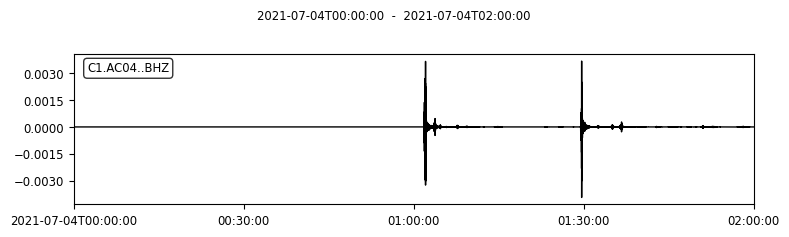

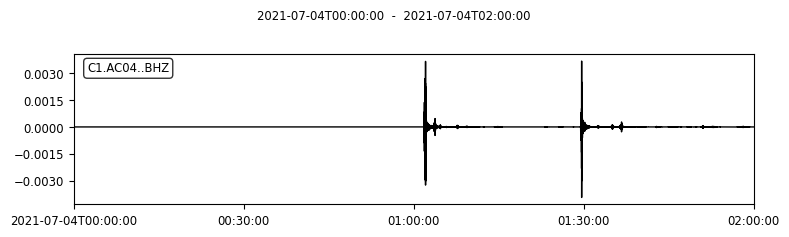

In [16]:
st_AC04[2].plot(startime = st_AC04[2].stats.starttime, endtime = st_AC04[2].stats.starttime + 60*60*2)

# 2. Cálculo del p_picking para cada estación por separado

## 2.1. Se establecen los parámetros de la función

In [17]:
coord_AC04 = (-28.20, -71.07)
coord_AC05 = (-28.84, -70.27)
coord_CO05 = (-29.92, -71.24)
coord_C010 = (-29.24, -71.46)

#Lista de estaciones
stations = [st_AC04, st_AC05, st_CO05, st_CO10]

#Lista de Coordenadas
coord_list = [coord_AC04, coord_AC05, coord_CO05, coord_C010]

#Valores en segundos de las ventanas de tiempo en que se mueven las ventanas
ventana_10s = 10
ventana_30s = 30

#Velocidad de propagación de la onda P
v_P = 8.046 


## **NO CORRER A MENOS QUE SE QUIERAN OPTIMIZAR PARAMETROS** 2.2. Se optimizan los parámetros nsta, nlta y threshold para cada estación

In [18]:
# Parametros sta/lta a optimizar 

#nsta_values = [1.5, 1.7, 1.8, 2, 2.3, 2.5, 2,7, 3, 3.2, 3.5]
#nlta_values = [8, 9, 9.5, 10, 10.5, 11, 11.5, 12, 13]
#thr_on_values = [3.7, 3.8, 4, 4.3, 4.5, 4.7, 4,95, 5, 5.2, 5.5, 5.7, 6, 6.5, 7]
thr_off = 3 # solo sirve al momento de hacer plot_trigger, por lo que no es necesario cambiarlo para buscar eventos

nsta_values = [2]
nlta_values = [10]
thr_on_values = [4]

pick_func = 'p_picking_each'
filename = 'times_events_24hrs_all.txt'
best_params_AC04 = optimize_parameters(pick_func, nsta_values, nlta_values, thr_on_values, thr_off, st_AC04, ventana_10s, ventana_30s, v_P, coord_list, filename)
best_params_AC05 = optimize_parameters(pick_func, nsta_values, nlta_values, thr_on_values, thr_off, st_AC05, ventana_10s, ventana_30s, v_P, coord_list, filename)
best_params_CO05 = optimize_parameters(pick_func, nsta_values, nlta_values, thr_on_values, thr_off, st_CO05, ventana_10s, ventana_30s, v_P, coord_list, filename)
best_params_CO10 = optimize_parameters(pick_func, nsta_values, nlta_values, thr_on_values, thr_off, st_CO10, ventana_10s, ventana_30s, v_P, coord_list, filename)

#save the best params for each station as a pickle file 
if not os.path.exists('best_params_all.pkl'):
    filename = 'best_params_all.pkl'
else:
    filename = 'best_params_all_v2.pkl'
    
with open(filename, 'wb') as f:
    pickle.dump([best_params_AC04, best_params_AC05, best_params_CO05, best_params_CO10], f)


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


In [19]:
#load the best params for each station from a pickle file
with open('best_params_all_v2.pkl', 'rb') as f:
    best_params_AC04, best_params_AC05, best_params_CO05, best_params_CO10 = pickle.load(f)

best_params_all = [best_params_AC04, best_params_AC05, best_params_CO05, best_params_CO10]

stations_names = []
for i in range(len(stations)):
    stations_names.append(stations[i][0].stats.station)

best_params = {}
for i in range(len(stations)):
    best_params[stations_names[i]] = max(best_params_all[i], key=best_params_all[i].get)



## 2.3. Se calcula el p_picking para cada estación por separado usando los mejores parametros antes calculados

In [20]:
# aplicar p_picking_each a cada estación de stations usando list comprehension
nsta_list, nlta_list, thr_on_list, thr_off_list = zip(*[best_params[st] for st in stations_names])


# Esto es para cuando necesito sacar los resultados de antes de la reunión del 5 de enero
#nsta, nlta, thr_on, thr_off = (2, 10, 4.92, 3)
#p_times = [p_picking_each(st, ventana_10s, ventana_30s, nsta, nlta, thr_on, thr_off) for st in stations]

p_times = [p_picking_each(st, ventana_10s, ventana_30s, nsta, nlta, thr_on, thr_off) for st, nsta, nlta, thr_on, thr_off 
           in zip(stations, nsta_list, nlta_list, thr_on_list, thr_off_list)]

# Guardar los tiempos detectados de cada estación en un archivo txt con un nombre representativo a la estación
for i in range(len(stations)):
    np.savetxt('time_trigger_{}.txt'.format(stations_names[i]), p_times[i], fmt='%s')

## 2.4. Cálculo y visualización de los resultados del p_picking

In [72]:
# Función para leer tiempos de un archivo
def read_times(filename, time_format, skip_header=True):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        if skip_header:
            next(reader)  # Saltar la cabecera
        return [datetime.strptime(row[0], time_format) for row in reader]

def calcular_metricas(path_reales, path_predichos):
    resultados_totales = []
    f_positivos = {}
    f_negativos = {}
    v_positivos = {}
    
    for path_predicho in path_predichos:
        identificador = os.path.splitext(os.path.basename(path_predicho))[0].split('_')[-1]

        tiempos_reales = read_times(path_reales, '%Y-%m-%dT%H:%M:%S')
        tiempos_predichos = read_times(path_predicho, '%Y-%m-%dT%H:%M:%S.%fZ', skip_header=False)

        conjunto_reales = set([t.replace(second=0) for t in tiempos_reales])
        conjunto_predichos = set([t.replace(second=0, microsecond=0) for t in tiempos_predichos])

        verdaderos_positivos = conjunto_reales & conjunto_predichos
        falsos_positivos = conjunto_predichos - conjunto_reales
        falsos_negativos = conjunto_reales - conjunto_predichos

        # Crear diccionarios para mapear cada tiempo a su segundo correspondiente
        dict_tiempos_reales = {t.replace(second=0): t.second for t in tiempos_reales}
        dict_tiempos_predichos = {t.replace(second=0, microsecond=0): t.second for t in tiempos_predichos}

        # Esto siguiente es para poder tener los tiempos con los segundos, y no solo las horas y minutos
        v_p = sorted([t.replace(second=dict_tiempos_predichos[t]) for t in verdaderos_positivos])
        f_p = sorted([t.replace(second=dict_tiempos_predichos[t]) for t in falsos_positivos])
        f_n = sorted([t.replace(second=dict_tiempos_reales[t]) for t in falsos_negativos])

        resultados = {'Verdaderos Positivos': len(verdaderos_positivos),
                      'Falsos Positivos': len(falsos_positivos),
                      'Falsos Negativos': len(falsos_negativos)}

        presicion = len(verdaderos_positivos) / (len(verdaderos_positivos) + len(falsos_positivos))
        recall = len(verdaderos_positivos) / (len(verdaderos_positivos) + len(falsos_negativos))
        f1_score = 2 * (presicion * recall) / (presicion + recall)

        presicion = round(presicion, 2)
        recall = round(recall, 2)
        f1_score = round(f1_score, 2)

        resultados_totales.append({
            'identificador': identificador,
            'resultados': resultados,
            'presicion': presicion,
            'recall': recall,
            'f1_score': f1_score
        })


        f_positivos[identificador] = list(f_p)
        f_negativos[identificador] = list(f_n)
        v_positivos[identificador] = list(v_p)

    return resultados_totales, f_negativos, f_positivos, v_positivos

# Uso de la función y posterior impresión
path_reales = ['times_events_24hrs_all.txt', 'times_events_24hrs_sup30.txt', 'times_events_24hrs_sup35.txt', 'times_events_24hrs_sup40.txt']
path_predichos = ['time_trigger_AC04.txt', 'time_trigger_AC05.txt', 'time_trigger_CO05.txt', 'time_trigger_CO10.txt']
titles = ['para todos los eventos ', 'para eventos superiores a 3 grados', 'para eventos superiores a 3.5 grados', 'para eventos superiores a 4 grados']

results_no_val, f_neg_no_val, f_pos_no_val, t_pos_no_val = calcular_metricas(path_reales[3], path_predichos)

In [73]:
plot_bar(results_no_val, titles[3])
#plot_metrics(results_no_val, titles[3])

## 2.5. Visualización de las señales donde existen falsos positivos y falsos negativos

### 2.5.1 Se selecciona el canal Z de todas las estaciones

In [74]:
#selecciona el canal BHZ de AC04
st_AC04_BHZ = st_AC04.select(channel='BHZ')
#selecciona el canal BHZ de AC05
st_AC05_BHZ = st_AC05.select(channel='BHZ')
#selecciona el canal BHZ de CO05
st_CO05_BHZ = st_CO05.select(channel='BHZ')
#selecciona el canal BHZ de CO10
st_CO10_BHZ = st_CO10.select(channel='BHZ')

### 2.5.2 Se crean variables para guardar TP, FN y FP para cada estación

In [75]:
falsos_positivos_AC04 = f_pos_no_val['AC04']
falsos_negativos_AC04 = f_neg_no_val['AC04']
verdaderos_positivos_AC04 = t_pos_no_val['AC04']

falsos_positivos_AC05 = f_pos_no_val['AC05']
falsos_negativos_AC05 = f_neg_no_val['AC05']
verdaderos_positivos_AC05 = t_pos_no_val['AC05']

falsos_positivos_CO05 = f_pos_no_val['CO05']
falsos_negativos_CO05 = f_neg_no_val['CO05']
verdaderos_positivos_CO05 = t_pos_no_val['CO05']

falsos_positivos_CO10 = f_pos_no_val['CO10']
falsos_negativos_CO10 = f_neg_no_val['CO10']
verdaderos_positivos_CO10 = t_pos_no_val['CO10']

### 2.5.3 Guardamos los TP, FN y FP que sean comunes en todas las estaciones

In [100]:
# Primero, agrupamos las listas por su tipo (falsos positivos, falsos negativos, verdaderos positivos)
falsos_positivos = [falsos_positivos_AC04, falsos_positivos_AC05, falsos_positivos_CO05, falsos_positivos_CO10]
falsos_negativos = [falsos_negativos_AC04, falsos_negativos_AC05, falsos_negativos_CO05, falsos_negativos_CO10]
verdaderos_positivos = [verdaderos_positivos_AC04, verdaderos_positivos_AC05, verdaderos_positivos_CO05, verdaderos_positivos_CO10]

# Redondea los objetos datetime al segundo más cercano
verdaderos_positivos_redondeados = [[dt.replace(second=0) for dt in lista] for lista in verdaderos_positivos]

# Luego, usamos la función set.intersection para encontrar los elementos comunes en todas las listas
falsos_positivos_comunes = set(falsos_positivos[0]).intersection(*falsos_positivos)
falsos_negativos_comunes = set(falsos_negativos[0]).intersection(*falsos_negativos)
verdaderos_positivos_comunes = set(verdaderos_positivos_redondeados[0]).intersection(*verdaderos_positivos_redondeados)

# Ahora, falsos_positivos_comunes, falsos_negativos_comunes y verdaderos_positivos_comunes contienen los elementos datetime.DateTime que están en todas las listas respectivas a sus estaciones.


In [102]:
falsos_negativos_comunes 

{datetime.datetime(2021, 7, 4, 1, 36, 16)}

### 2.5.4 Tomamos el tiempo en que los falsos negativos deberían verse en cada estación según la estimación

In [115]:
file_name = 'times_events_24hrs_sup40.txt'

with open(file_name, 'r') as file:
    lines = file.readlines()

# Get the column names from the first line
column_names = lines[0].strip().split(',')

# Find the positions of the desired columns
date_index = column_names.index('Fecha UTC')
detection_indices = {
    'AC04': column_names.index('Hora detección estación AC04'),
    'AC05': column_names.index('Hora detección estación AC05'),
    'CO05': column_names.index('Hora detección estación CO05'),
    'CO10': column_names.index('Hora detección estación CO10'),
}

# Remove the first line (header)
lines = lines[1:]

# Create empty dictionaries to store the detection times
fneg_det_times = {
    'AC04': [],
    'AC05': [],
    'CO05': [],
    'CO10': [],
}

# Go through each line in the file
for line in lines:
    # Split the line into columns
    columns = line.split(',')
    
    # Convert the event date to a datetime object
    event_date = datetime.strptime(columns[date_index], '%Y-%m-%dT%H:%M:%S')
    
    # If the event date is in common_false_negatives
    if event_date in falsos_negativos_comunes:
        # Store the detection times in their respective lists
        for station, index in detection_indices.items():
            fneg_det_times[station].append(datetime.strptime(columns[index], '%Y-%m-%dT%H:%M:%S'))

# Now detection_times contains the detection times for each station



In [116]:
fneg_det_times

{'AC04': [datetime.datetime(2021, 7, 4, 1, 36, 24)],
 'AC05': [datetime.datetime(2021, 7, 4, 1, 36, 30)],
 'CO05': [datetime.datetime(2021, 7, 4, 1, 36, 32)],
 'CO10': [datetime.datetime(2021, 7, 4, 1, 36, 22)]}

### 2.5.3 Se selecciona cuál de los eventos donde hay falsos positivos y falsos negativos se quiere analizar para cada estación

In [122]:
falsos_positivos_AC04[f_p]

datetime.datetime(2021, 7, 4, 0, 0)

In [118]:
# Indice del evento problemático a analizar
f_p = 0
f_n = 0

fneg_AC04 = fneg_det_times['AC04'][f_n]
fneg_AC05 = fneg_det_times['AC05'][f_n]
fneg_CO05  = fneg_det_times['CO05'][f_n]
fneg_CO10 = fneg_det_times['CO10'][f_n]


# Estación AC04
start_time_fp_AC04 = UTCDateTime(falsos_positivos_AC04[f_p] - timedelta(seconds=30))
start_time_fn_AC04 = UTCDateTime(fneg_AC04 - timedelta(seconds=30))

# Estación AC05
start_time_fp_AC05 = UTCDateTime(falsos_positivos_AC05[f_p] - timedelta(seconds=30))
start_time_fn_AC05 = UTCDateTime(fneg_AC05 - timedelta(seconds=30))  

# Estación CO05
start_time_fp_CO05 = UTCDateTime(falsos_positivos_CO05[f_p] - timedelta(seconds=30))
start_time_fn_CO05 = UTCDateTime(fneg_CO05  - timedelta(seconds=30))

# Estación CO10
start_time_fp_CO10 = UTCDateTime(falsos_positivos_CO10[f_p] - timedelta(seconds=30))
start_time_fn_CO10 = UTCDateTime(fneg_CO10 - timedelta(seconds=30))

### 2.5.4 Tomamos las trazas que corresponden al encuentro antes precisado con algun FP o FN 

In [119]:
# Se toma la parte de la traza que pertenece al falso positivo para cada estación
st_AC04_BHZ_fp = st_AC04_BHZ.slice(start_time_fp_AC04, start_time_fp_AC04 + 60)
st_AC05_BHZ_fp = st_AC05_BHZ.slice(start_time_fp_AC05, start_time_fp_AC05 + 60)
st_CO05_BHZ_fp = st_CO05_BHZ.slice(start_time_fp_CO05, start_time_fp_CO05 + 60)
st_CO10_BHZ_fp = st_CO10_BHZ.slice(start_time_fp_CO10, start_time_fp_CO10 + 60)

# Se toma la parte de la traza que pertenece al falso negativo para cada estación
st_AC04_BHZ_fn = st_AC04_BHZ.slice(start_time_fn_AC04, start_time_fn_AC04 + 60)
st_AC05_BHZ_fn = st_AC05_BHZ.slice(start_time_fn_AC04, start_time_fn_AC04 + 60)
st_CO05_BHZ_fn = st_CO05_BHZ.slice(start_time_fn_CO05, start_time_fn_CO05 + 60)
st_CO10_BHZ_fn = st_CO10_BHZ.slice(start_time_fn_CO10, start_time_fn_CO10 + 60)

### 2.5.5 Se grafican las trazas problemáticas

#### 2.5.5.1 Plot de las trazas con falsos positivos

In [123]:
st_AC04_BHZ_fp[0]

C1.AC04..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-04T00:00:30.000000Z | 40.0 Hz, 1201 samples

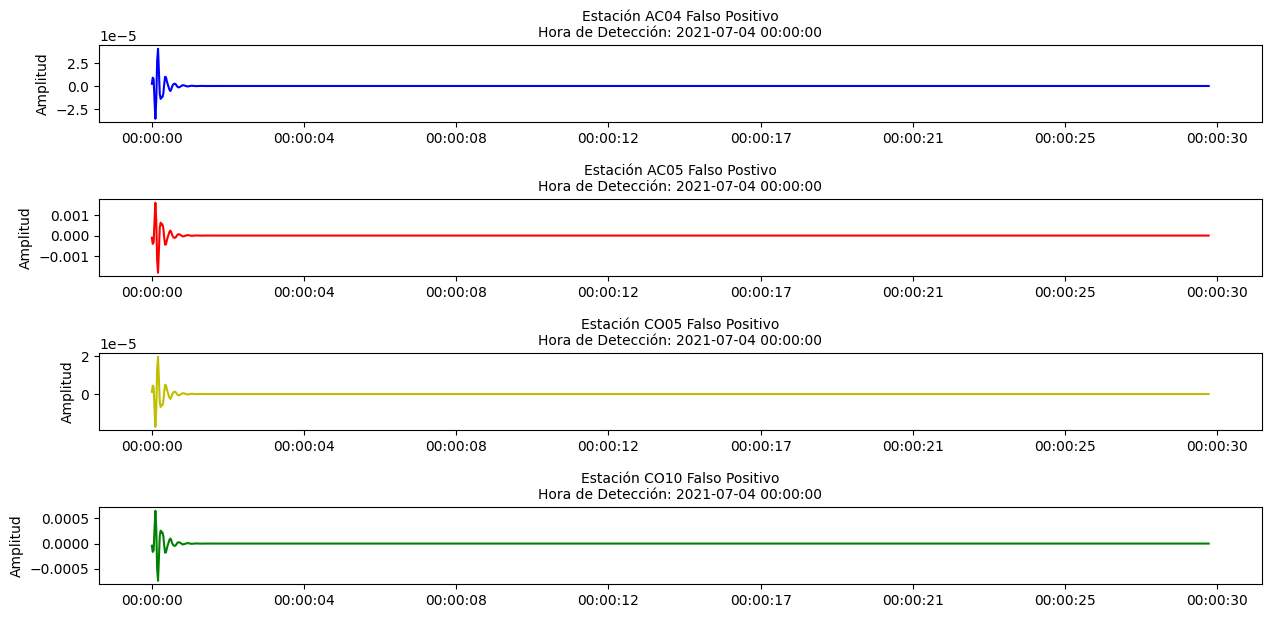

In [120]:
fig, axs = plt.subplots(4, 1, figsize=(15, 7), sharex=False)
fig.subplots_adjust(hspace = 1)

# Estación AC04
axs[0].plot(st_AC04_BHZ_fp[0].times("matplotlib"), st_AC04_BHZ_fp[0].data, '-b')
axs[0].set_title(f'Estación AC04 Falso Positivo\nHora de Detección: {falsos_positivos_AC04[f_p]}', size=10)
axs[0].set_ylabel('Amplitud')
#axs[0].xaxis_date()


# Estación AC05
axs[1].plot(st_AC05_BHZ_fp[0].times("matplotlib"), st_AC05_BHZ_fp[0].data, '-r')
axs[1].set_title(f'Estación AC05 Falso Postivo\nHora de Detección: {falsos_positivos_AC05[f_p]}', size=10)
axs[1].set_ylabel('Amplitud')
#axs[1].xaxis_date()

# Estación CO05
axs[2].plot(st_CO05_BHZ_fp[0].times("matplotlib"), st_CO05_BHZ_fp[0].data, '-y')
axs[2].set_title(f'Estación CO05 Falso Positivo\nHora de Detección: {falsos_positivos_CO05[f_p]}', size=10)
axs[2].set_ylabel('Amplitud')
#axs[2].xaxis_date()

# Estación CO10
axs[3].plot(st_CO10_BHZ_fp[0].times("matplotlib"), st_CO10_BHZ_fp[0].data, '-g')
axs[3].set_title(f'Estación CO10 Falso Positivo\nHora de Detección: {falsos_positivos_CO10[f_p]}', size=10)
axs[3].set_ylabel('Amplitud')
axs[3].set_xlabel('')
#axs[3].xaxis_date()

# Configurar manualmente el eje x para cada subtrama
for ax in axs:
    ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

plt.show()

In [41]:
st_AC04_BHZ_fp[0].data

array([ 4.39987057e-08,  7.98991911e-08,  4.89186639e-08, ...,
        3.48056212e-07, -9.06861962e-07, -1.35634201e-06])

In [33]:
max_amplitude = st_AC04_BHZ_fp[0].data.max()
peak_index = st_AC04_BHZ_fp[0].data.argmax()

threshold = 0.03 * max_amplitude

for i in range(peak_index, len(st_AC04_BHZ_fp[0].data)):
    if st_AC04_BHZ_fp[0].data[i] < threshold:
        endpoint = i
        break



In [46]:
# Obtener los datos de la traza
data = st_AC04_BHZ_fp[0].data

# Calcular la energía en cada punto
window_size = 50  # Puedes ajustar el tamaño de la ventana según tus necesidades
energy = np.convolve(data**2, np.ones(window_size)/window_size, mode='valid')

# Encontrar el pico de energía
max_energy = np.max(energy)
peak_index_energy = np.argmax(energy)

# Calcular el 3% del pico de energía
threshold_energy = 0.03 * max_energy

# Encontrar el punto donde la señal baja del 3% después del pico
for i in range(peak_index_energy, len(energy)):
    if energy[i] < threshold_energy:
        endpoint_energy = i
        break

print("El tiempo de partida es:", st_AC04_BHZ_fp[0].stats.starttime.strftime("%Y-%m-%dT%H:%M"))
print("Punto con mayor energía en samples:", peak_index_energy)
print("Punto con mayor energía en segundos (desde el tiempo de partida):", peak_index_energy/40)
print("El valor de la energía ")
print(f"Desde el peak de energía hasta que baja del 3% de esta hay {(endpoint_energy -peak_index_energy)/40} segundos")

2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
El tiempo de partida es: 2021-07-04T02:45
Punto con mayor energía en samples: 2248
Punto con mayor energía en segundos (desde el tiempo de partida): 56.2
El valor de la energía 


NameError: name 'endpoint_energy' is not defined

In [47]:
# Obtener los datos de la traza
data = st_AC04_BHZ_fp[0].data

# Calcular la amplitud en cada punto
amplitude = np.abs(data)

# Encontrar el pico de amplitud
max_amplitude = np.max(amplitude)
peak_index_amplitude = np.argmax(amplitude)

# Calcular el 3% del pico de amplitud
threshold_amplitude = 0.03 * max_amplitude

# Encontrar el punto donde la señal baja del 3% después del pico
for i in range(peak_index_amplitude, len(amplitude)):
    if amplitude[i] < threshold_amplitude:
        endpoint_amplitude = i
        break

print("El tiempo de partida es:", st_AC04_BHZ_fp[0].stats.starttime.strftime("%Y-%m-%dT%H:%M"))
print("Punto con mayor energía en samples:", peak_index_amplitude)
print("Punto con mayor energía en segundos (desde el tiempo de partida):", peak_index_amplitude)
print(f"Desde el peak de energía hasta que baja del 3% de esta hay {(endpoint_amplitude - peak_index_amplitude)/40} segundos")

El tiempo de partida es: 2021-07-04T02:45
Punto con mayor energía en samples: 2319
Punto con mayor energía en segundos (desde el tiempo de partida): 2319
Desde el peak de energía hasta que baja del 3% de esta hay 0.8 segundos


#### 2.5.5.2 Plot de las trazas con falsos negativos

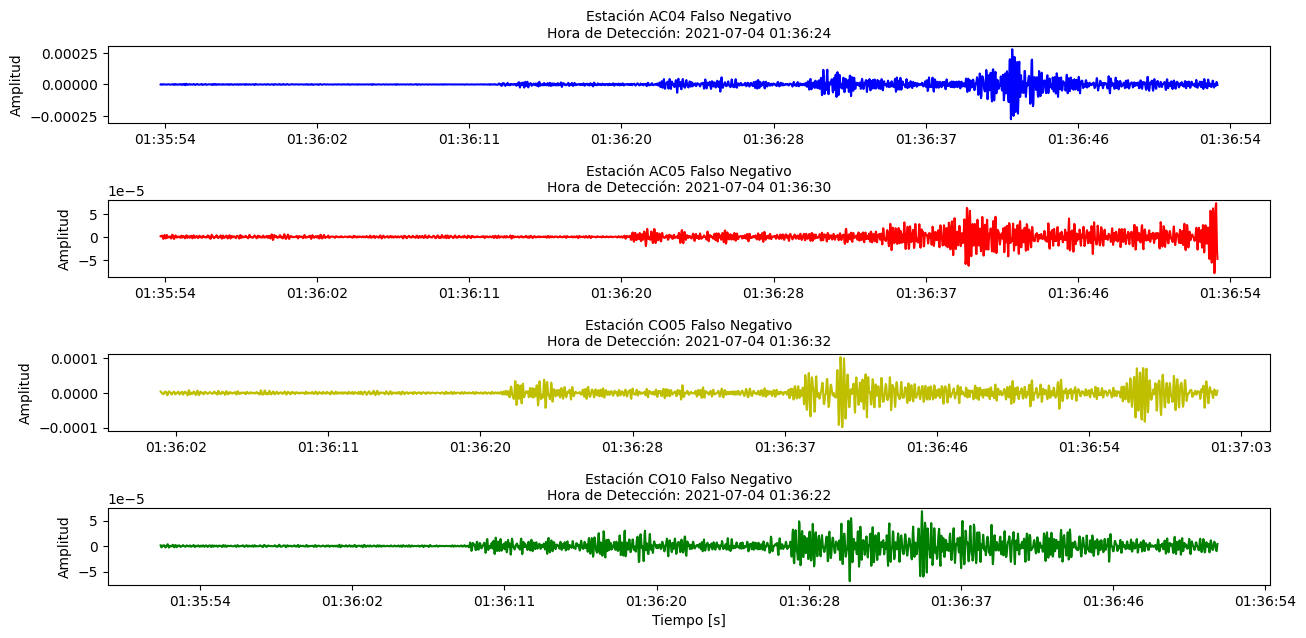

In [121]:
fig, axs = plt.subplots(4, 1, figsize=(15, 7), sharex=False)
fig.subplots_adjust(hspace = 1)


# Estación AC04
axs[0].plot(st_AC04_BHZ_fn[0].times("matplotlib"), st_AC04_BHZ_fn[0].data, '-b') 
axs[0].set_title(f'Estación AC04 Falso Negativo\nHora de Detección: {fneg_AC04}', size=10)
axs[0].set_ylabel('Amplitud')
#axs[0].xaxis_date()


# Estación AC05
axs[1].plot(st_AC05_BHZ_fn[0].times("matplotlib"), st_AC05_BHZ_fn[0].data, '-r')
axs[1].set_title(f'Estación AC05 Falso Negativo\nHora de Detección: {fneg_AC05}', size=10)
axs[1].set_ylabel('Amplitud')
#axs[1].xaxis_date()

# Estación CO05
axs[2].plot(st_CO05_BHZ_fn[0].times("matplotlib"), st_CO05_BHZ_fn[0].data, '-y')
axs[2].set_title(f'Estación CO05 Falso Negativo\nHora de Detección: {fneg_CO05}', size=10)
axs[2].set_ylabel('Amplitud')
#axs[2].xaxis_date()

# Estación CO10
axs[3].plot(st_CO10_BHZ_fn[0].times("matplotlib"), st_CO10_BHZ_fn[0].data, '-g')
axs[3].set_title(f'Estación CO10 Falso Negativo\nHora de Detección: {fneg_CO10}', size=10)
axs[3].set_ylabel('Amplitud')
axs[3].set_xlabel('Tiempo [s]')
#axs[3].xaxis_date()

# Configurar manualmente el eje x para cada subtrama
for ax in axs:
    ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

plt.show()

# 3. Se comparan los tiempos de detección de cada estación con sus dos estaciones más cercanas

## 3.1. Calculo de distancia y tiempo entre estaciones

In [49]:
# Coordenadas (latitud, longitud) de las estaciones y selección de canal para cada estación
station_coords = [coord for coord in coord_list]
station_traces = [station.select(channel='BHZ')[0] for station in stations]

# Distancia y tiempo de llegada de la onda P entre todas las estaciones
distance_matrix = [[geodesic(coord1, coord2).kilometers for coord2 in station_coords] for coord1 in station_coords]
time_matrix = [[d_val / v_P for d_val in d_row] for d_row in distance_matrix]

# Diccionario con cada estación como llave y distancia a las otras estaciones como valor
distance_dict = {stations[i][0].stats.station: distance_matrix[i] for i in range(len(stations))}

# Diccionario con cada estación como llave y timepo a las otras estaciones como valor
time_dict = {stations[i][0].stats.station: time_matrix[i] for i in range(len(stations))}

# Diccionario con cada estación como llave y el tiempo de os trigger como valor
p_times_dict = {stations[i][0].stats.station: p_times[i] for i in range(len(stations))}


## 3.2. Comparación de tiempos de detección entre estaciones considerando la distancia entre ellas 

In [54]:
def get_common_events(p_times_dict, time_dict, error):

    event_dict = dict.fromkeys(p_times_dict.keys())
    
    for station_1, event_station_1 in p_times_dict.items():
        # Establesco las dos estaciones más cercanas, que es donde verifica´re si el evento es real o no
        closest_stations = sorted(range(len(time_dict[station_1])), key=lambda i: time_dict[station_1][i])[1:3]
        name_closest_stations = [list(time_dict.keys())[i] for i in closest_stations]
        event_next_stations = [time_dict[station_1][i] for i in closest_stations]
        event_list = []
        for event in event_station_1:
            candidate_time_range = [event - error - max(event_next_stations), event + error + max(event_next_stations)]
            conditions_met = []
            for closest_station in name_closest_stations:
                for event_2 in p_times_dict[closest_station]:
                    if candidate_time_range[0] <= event_2 <= candidate_time_range[1]:
                        conditions_met.append(True)
                        
            if all(conditions_met)and len(conditions_met) == len(name_closest_stations):
                event_list.append(event)
                #event_dict[station_1] = event
            event_dict[station_1] = event_list

    return event_dict

event_dict = get_common_events(p_times_dict, time_dict, 2)


# 4. Vemos como quedan los TP, FN y FP para cada estación luego de la comparación con las estaciones vecinas

## 4.1. Guardamos como archivos de texto los tiempos de los eventos luego de la comparación con las estaciones vecinas

In [55]:
for i, station in enumerate(event_dict):
    station_name = stations[i][0].stats.station 
    np.savetxt('time_trigger_val_{}.txt'.format(station_name), event_dict[station], fmt='%s')

## 4.2. Vemos cuantos de los nuevos eventos de cada estación pertenecen verdaderamente a un evento real

In [59]:
# Uso de la función y posterior impresión
path_reales = ['times_events_24hrs_all.txt', 'times_events_24hrs_sup30.txt', 'times_events_24hrs_sup35.txt', 'times_events_24hrs_sup40.txt']
path_predichos = ['time_trigger_val_AC04.txt', 'time_trigger_val_AC05.txt', 'time_trigger_val_CO05.txt', 'time_trigger_val_CO10.txt']
titles = ['para todos los eventos ', 'para eventos superiores a 3 grados', 'para eventos superiores a 3.5 grados', 'para eventos superiores a 4 grados']

results_with_val, f_neg_val, f_pos_val, t_pos_val = calcular_metricas(path_reales[3], path_predichos)

In [60]:
plot_metrics(results_with_val, titles[3])
plot_bar(results_with_val, titles[3])

## 4.5. Visualización de las señales donde existen falsos positivos y falsos negativos

### 4.5.2 Se crean variables para guardar TP, FN y FP para cada estación

In [61]:
falsos_positivos_AC04 = f_pos_val['AC04']
falsos_negativos_AC04 = f_neg_val['AC04']
verdaderos_positivos_AC04 = t_pos_val['AC04']

falsos_positivos_AC05 = f_pos_val['AC05']
falsos_negativos_AC05 = f_neg_val['AC05']
verdaderos_positivos_AC05 = t_pos_val['AC05']

falsos_positivos_CO05 = f_pos_val['CO05']
falsos_negativos_CO05 = f_neg_val['CO05']
verdaderos_positivos_CO05 = t_pos_val['CO05']

falsos_positivos_CO10 = f_pos_val['CO10']
falsos_negativos_CO10 = f_neg_val['CO10']
verdaderos_positivos_CO10 = t_pos_val['CO10']

### 4.5.3 Se selecciona cual de los eventos donde hay falsos positivos y falsos negativos se quiere analizar para cada estación

In [62]:
# Indice del evento problemático a analizar
f_p = 1
f_n = 0

# Estación AC04
start_time_fp_AC04 = UTCDateTime(falsos_positivos_AC04[f_p] - timedelta(seconds=30))
start_time_fn_AC04 = UTCDateTime(falsos_negativos_AC04[f_n] - timedelta(seconds=30))

# Estación AC05
start_time_fp_AC05 = UTCDateTime(falsos_positivos_AC05[f_p] - timedelta(seconds=30))
start_time_fn_AC05 = UTCDateTime(falsos_negativos_AC05[f_n] - timedelta(seconds=30))  

# Estación CO05
start_time_fp_CO05 = UTCDateTime(falsos_positivos_CO05[f_p] - timedelta(seconds=30))
start_time_fn_CO05 = UTCDateTime(falsos_negativos_CO05[f_n] - timedelta(seconds=30))

# Estación CO10
start_time_fp_CO10 = UTCDateTime(falsos_positivos_CO10[f_p] - timedelta(seconds=30))
start_time_fn_CO10 = UTCDateTime(falsos_negativos_CO10[f_n] - timedelta(seconds=30))

### 4.5.4 Tomamos las trazas que corresponden al encuentro antes precisado con algun FP o FN 

In [ ]:
# Se toma la parte de la traza que pertenece al falso positivo para cada estación
st_AC04_BHZ_fp = st_AC04_BHZ.slice(start_time_fp_AC04, start_time_fp_AC04 + 60)
st_AC05_BHZ_fp = st_AC05_BHZ.slice(start_time_fp_AC05, start_time_fp_AC05 + 60)
st_CO05_BHZ_fp = st_CO05_BHZ.slice(start_time_fp_CO05, start_time_fp_CO05 + 60)
st_CO10_BHZ_fp = st_CO10_BHZ.slice(start_time_fp_CO10, start_time_fp_CO10 + 60)

# Se toma la parte de la traza que pertenece al falso negativo para cada estación
st_AC04_BHZ_fn = st_AC04_BHZ.slice(start_time_fn_AC04, start_time_fn_AC04 + 60)
st_AC05_BHZ_fn = st_AC05_BHZ.slice(start_time_fn_AC04, start_time_fn_AC04 + 60)
st_CO05_BHZ_fn = st_CO05_BHZ.slice(start_time_fn_CO05, start_time_fn_CO05 + 60)
st_CO10_BHZ_fn = st_CO10_BHZ.slice(start_time_fn_CO10, start_time_fn_CO10 + 60)

### 4.5.5 Se grafican las trazas problemáticas

#### 4.5.5.1 Plot de las trazas con falsos positivos

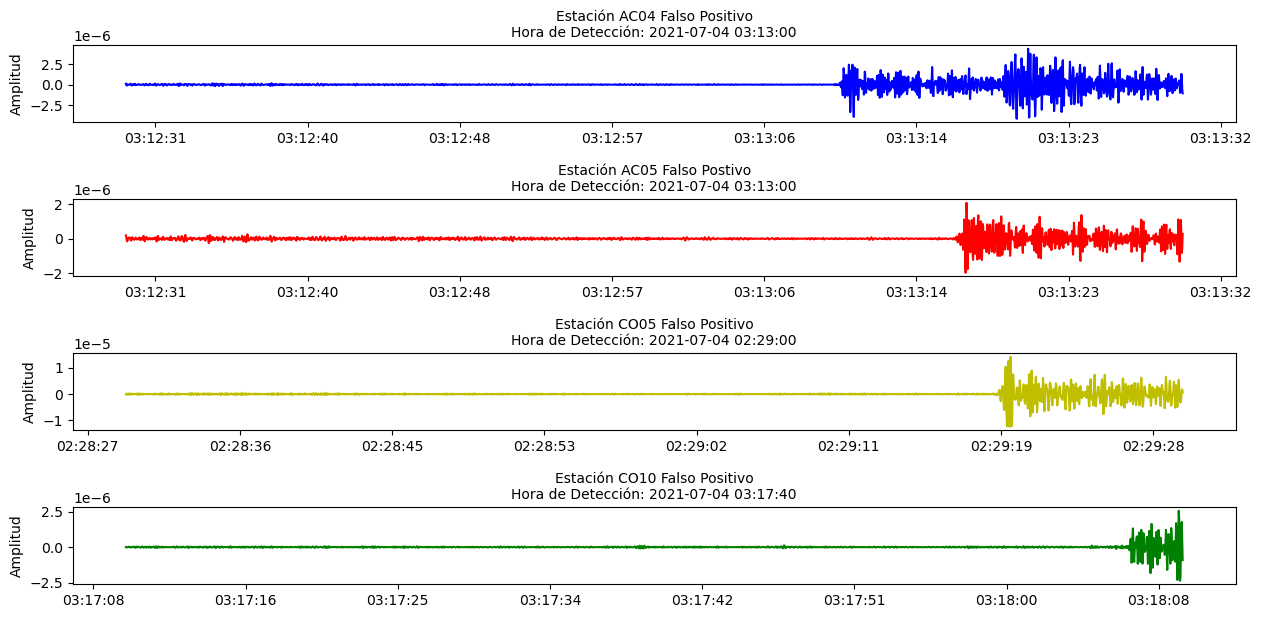

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(15, 7), sharex=False)
fig.subplots_adjust(hspace = 1)

# Estación AC04
axs[0].plot(st_AC04_BHZ_fp[0].times("matplotlib"), st_AC04_BHZ_fp[0].data, '-b')
axs[0].set_title(f'Estación AC04 Falso Positivo\nHora de Detección: {falsos_positivos_AC04[f_p]}', size=10)
axs[0].set_ylabel('Amplitud')
#axs[0].xaxis_date()


# Estación AC05
axs[1].plot(st_AC05_BHZ_fp[0].times("matplotlib"), st_AC05_BHZ_fp[0].data, '-r')
axs[1].set_title(f'Estación AC05 Falso Postivo\nHora de Detección: {falsos_positivos_AC05[f_p]}', size=10)
axs[1].set_ylabel('Amplitud')
#axs[1].xaxis_date()

# Estación CO05
axs[2].plot(st_CO05_BHZ_fp[0].times("matplotlib"), st_CO05_BHZ_fp[0].data, '-y')
axs[2].set_title(f'Estación CO05 Falso Positivo\nHora de Detección: {falsos_positivos_CO05[f_p]}', size=10)
axs[2].set_ylabel('Amplitud')
#axs[2].xaxis_date()

# Estación CO10
axs[3].plot(st_CO10_BHZ_fp[0].times("matplotlib"), st_CO10_BHZ_fp[0].data, '-g')
axs[3].set_title(f'Estación CO10 Falso Positivo\nHora de Detección: {falsos_positivos_CO10[f_p]}', size=10)
axs[3].set_ylabel('Amplitud')
axs[3].set_xlabel('')
#axs[3].xaxis_date()

# Configurar manualmente el eje x para cada subtrama
for ax in axs:
    ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

#### 4.5.5.2 Plot de las trazas con falsos negativos

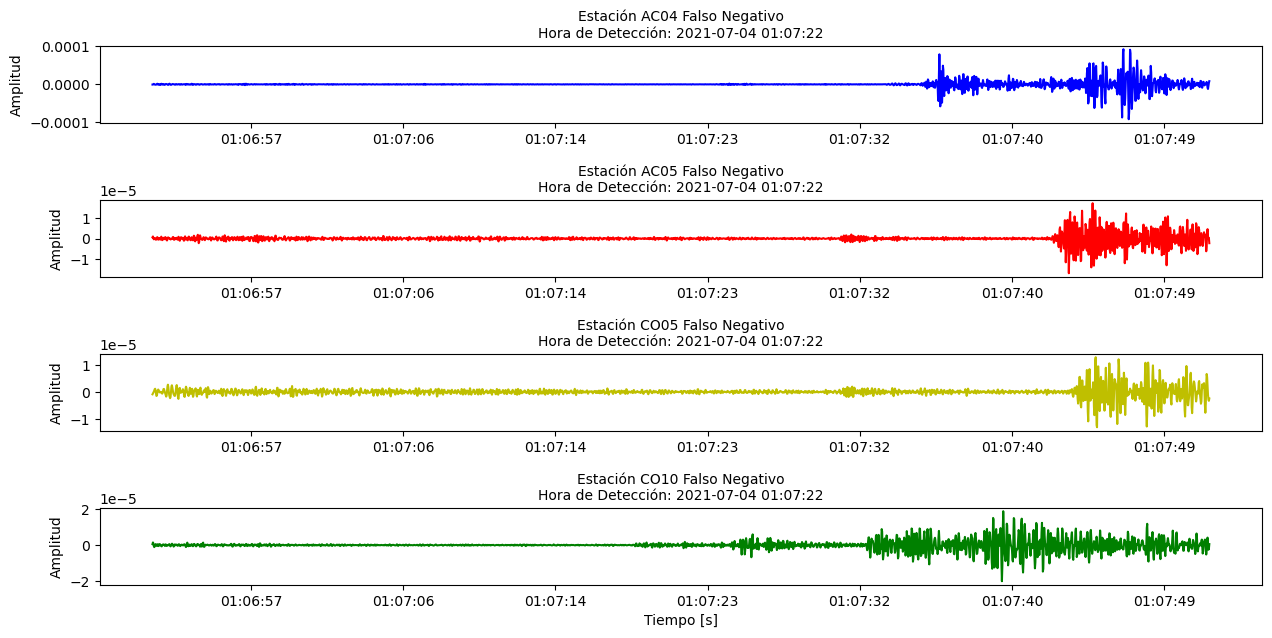

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(15, 7), sharex=False)
fig.subplots_adjust(hspace = 1)


# Estación AC04
axs[0].plot(st_AC04_BHZ_fn[0].times("matplotlib"), st_AC04_BHZ_fn[0].data, '-b')
axs[0].set_title(f'Estación AC04 Falso Negativo\nHora de Detección: {falsos_negativos_AC04[f_n]}', size=10)
axs[0].set_ylabel('Amplitud')
#axs[0].xaxis_date()


# Estación AC05
axs[1].plot(st_AC05_BHZ_fn[0].times("matplotlib"), st_AC05_BHZ_fn[0].data, '-r')
axs[1].set_title(f'Estación AC05 Falso Negativo\nHora de Detección: {falsos_negativos_AC05[f_n]}', size=10)
axs[1].set_ylabel('Amplitud')
#axs[1].xaxis_date()

# Estación CO05
axs[2].plot(st_CO05_BHZ_fn[0].times("matplotlib"), st_CO05_BHZ_fn[0].data, '-y')
axs[2].set_title(f'Estación CO05 Falso Negativo\nHora de Detección: {falsos_negativos_CO05[f_n]}', size=10)
axs[2].set_ylabel('Amplitud')
#axs[2].xaxis_date()

# Estación CO10
axs[3].plot(st_CO10_BHZ_fn[0].times("matplotlib"), st_CO10_BHZ_fn[0].data, '-g')
axs[3].set_title(f'Estación CO10 Falso Negativo\nHora de Detección: {falsos_negativos_CO10[f_n]}', size=10)
axs[3].set_ylabel('Amplitud')
axs[3].set_xlabel('Tiempo [s]')
#axs[3].xaxis_date()

# Configurar manualmente el eje x para cada subtrama
for ax in axs:
    ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

plt.show()

# 5. Ploteo de la diferencia de métricas antes de la validación y posterior a la validación

## 5.1. Plot de las métricas Precision, Recall y F1-Score antes y después de la validación

In [ ]:
resultados_totales = []

for before, after in zip(results_no_val, results_with_val):
    before = before.copy()
    before['identificador'] += ' (sin val)'
    resultados_totales.append(before)

    after = after.copy()
    after['identificador'] += ' (con val)'
    resultados_totales.append(after)


plot_metrics(resultados_totales)
plot_differences_amount(results_no_val, results_with_val)
plot_differences_bar(results_no_val, results_with_val)
plot_differences_scatter(results_no_val, results_with_val)


## 5.2. Plot de las métricas TP, FN y FP antes y después de la validación

In [ ]:
resultados_totales = []

for before, after in zip(results_no_val, results_with_val):
    before = before.copy()
    before['identificador'] += ' (sin val)'
    resultados_totales.append(before)

    after = after.copy()
    after['identificador'] += ' (con val)'
    resultados_totales.append(after)


plot_bar(resultados_totales)
plot_differences_amount(results_no_val, results_with_val, plot_metrics=False)
plot_differences_bar(results_no_val, results_with_val, plot_metrics=False)
plot_differences_scatter(results_no_val, results_with_val, plot_metrics=False)

In [ ]:

# rango de parámetros a probar
nsta_values = [1.5, 1.6, 1.8, 2, 2,5, 2,7, 3, 3.2]
nlta_values = [8, 10, 11, 12, 13]
thr_on_values = [3.5, 3.7, 3.8, 4, 4.2, 4.5, 4.7, 4,9, 5, 5.5,6, 6.5, 7, 7.5]
thr_off = 3 # solo sirve al momento de hacer plot_trigger, por lo que no es necesario cambiarlo para buscar eventos

best_params, worst_params, param_range = optimize_parameters(nsta_values, nlta_values, thr_on_values, thr_off, stations, ventana_10s, ventana_30s, v_P, coord_list)



In [ ]:
# Uso de la función
filename_best = 'best_params_v6.pkl' 
filename_worst = 'worst_params_v6.pkl'
filename_range = 'param_range_v6.pkl'

best_params = load_best_params(best_params, filename_best)
worst_params = load_best_params(worst_params, filename_worst)
param_range = load_best_params(param_range, filename_range)
ic(best_params, worst_params, param_range)



In [ ]:
# Imprimir la llave de la combinación de parámetros con el mejor resultado y el valor del resultado
best_key = max(best_params, key=best_params.get)
best_result = best_params[best_key]
print(f"Best parameters: {best_key}")
print(f"Best result: {best_result}")

In [ ]:
with open('times_events_24hrs_sup30.txt', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Saltar la cabecera
    tiempos_reales = [datetime.strptime(row[0], '%Y-%m-%dT%H:%M:%S') for row in reader]

### los mejores por exploración para superior o igual a 3.5 han sido:
- (3, 15, 4.99, 3) con un f1-score de 0.52
- (2, 10, 4.99, 3): presicion: 0.63 recall: 0.48 f1_score: 0.54
- (2.05, 12, 5.8, 3): presicion: 0.5, recall: 0.64, f1_score: 0.56
- (2.05, 12, 5.81, 3): presicion: 0.53 recall: 0.64 f1_score: 0.58
- (2.1, 12, 5.68, 3): len(time_all): 29 presicion: 0.52 recall: 0.6 f1_score: 0.56
- (2.5, 8, 3.19, 3): presicion: 0.5, recall: 0.6, f1_score: 0.55
- (1.8, 13, 7.2, 3): len(time_all): 24 presicion: 0.58 recall: 0.56 f1_score: 0.57

### los mejores por exploración para superior o igual a 3 han sido:
- (2, 13, 6.3, 3) presicion: 0.568 recall: 0.630 f1_score: 0.5979
- (2, 10, 4.92, 3) presicion: 0.62, recall: 0.61, f1_score: 0.62
- (5, 10, 1.98, 3) presicion: 0.52, recall: 0.72, f1_score: 0.61
- (3, 10, 3.3, 3) presicion: 0.6, recall: 0.63, f1_score: 0.62

In [ ]:
# Parámetros óptimos encontrados
nsta, nlta, thr_on, thr_off = (3, 10, 3.3, 3) # hacer nsta más grande, hace más chico el ratio. Hacer más grande nlta hace más grande el ratio
time_all = p_picking(stations, ventana_10s, ventana_30s, nsta, nlta, v_P, coord_list, thr_on, thr_off)

ic(len(time_all))
# Guardar los tiempos predichos
tiempos_predichos = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.%fZ') for time in time_all]
# Calcular los conjuntos de tiempos reales y predichos
conjunto_reales = set([t.replace(second=0) for t in tiempos_reales])
conjunto_predichos = set([t.replace(second=0, microsecond=0) for t in tiempos_predichos]) 
verdaderos_positivos = conjunto_reales & conjunto_predichos
falsos_positivos = conjunto_predichos - conjunto_reales
falsos_negativos = conjunto_reales - conjunto_predichos
presicion = len(verdaderos_positivos) / (len(verdaderos_positivos) + len(falsos_positivos))
recall = len(verdaderos_positivos) / (len(verdaderos_positivos) + len(falsos_negativos))
f1_score = 2 * (presicion * recall) / (presicion + recall)
#entrgar los resultados redondeados al segundo decimal
presicion = round(presicion, 2)
recall = round(recall, 2)
f1_score = round(f1_score, 2)
ic(presicion, recall, f1_score)

ic| len(time_all): 49
ic| presicion: 0.59, recall: 0.63, f1_score: 0.61


(0.59, 0.63, 0.61)

In [ ]:
len(tiempos_reales)

48

In [ ]:
nsta, nlta, thr_on, thr_off = (2, 10, 4, 3)
_,time_all1 = P_picking(stations, ventana_10s, ventana_30s, nsta, nlta, v_P, coord_list, thr_on, thr_off)

print(len(time_all1))

126


Guarda en un archivo de texto los tiempos de inicio y fin de cada evento detectado por todas las estaciones

In [ ]:
with open('time_trigger.txt', 'w') as archivo:
    archivo.write('\n'.join(str(time) for time in time_all))